In [1]:
import joblib
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns

import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
df_all = joblib.load('./dataframes/df_data.csv')
df_all = df_all[(df_all['year']>=2010) & (df_all['Bezirksname']!='Berlin')]

gentri_factor = joblib.load('./dataframes/gentri_factor.csv')
gentri_factor = gentri_factor

In [3]:
print(df_all.shape)
print(gentri_factor.shape)

(1360, 231)
(1360, 1)


In [4]:
df = pd.DataFrame(np.concatenate((df_all, gentri_factor), axis=1), columns=([c for c in df_all.columns] + ['factor']))

### Calculate Percentage Change for Factor

In [5]:
df['factor'] = df['factor'].replace(0, 0.001)

for l in tqdm(df['LOR'].unique()):
    current_year = df.loc[df['LOR']==l, 'factor']
    prior_year = df.loc[df['LOR']==l, 'factor'].shift(1)
    
    df.loc[df['LOR']==l, 'factor_cng'] = (current_year - prior_year) / prior_year
        
#replace inf values with the max of the column
df['factor_cng'].replace(np.inf, sorted(df['factor_cng'].unique())[-2], inplace=True)

100%|██████████| 136/136 [00:00<00:00, 248.33it/s]


### Time Lag t-1

In [6]:
cols = [c for c in df.columns if c not in ['Bezirk', 'Bezirksregion', 'LOR', 'Bezirksname', 'year', 'urban_style', 'Name']]

for col in tqdm(cols):
    for l in df['LOR'].unique():
        df.loc[df['LOR']==l, f'{col}_t-1'] = df.loc[df['LOR']==l, col].shift(1)

100%|██████████| 226/226 [01:33<00:00,  2.42it/s]


In [7]:
joblib.dump(df, './dataframes/df_predictions_2020.csv')

['./dataframes/df_predictions_2020.csv']

In [8]:
df = joblib.load('./dataframes/df_predictions_2020.csv')

In [9]:
#create target encoding for LOR

enc = {}
for l in df['LOR'].unique():
    enc[l] = np.mean(df.loc[df['LOR']==l, 'factor_cng'])

df['LOR_enc'] = df['LOR'].map(enc)
df.drop('LOR', axis=1, inplace=True)

In [10]:
shift_cols = [c for c in df.columns if 'cng_t-1' in c or 'perc_t-1' in c or c == 'factor_cng']

In [11]:
df[cols] = df[cols].astype('float')
df[shift_cols] = df[shift_cols].astype('float')

In [12]:
corr = df.loc[:, shift_cols].corr().loc[:, 'factor_cng']

In [13]:
corr.loc[corr < 0].sort_values().head(20)

former_JUGO_perc_cng_t-1        -0.173286
former_JUGO_cng_t-1             -0.165797
total_foreigners_perc_cng_t-1   -0.165116
total_foreigners_cng_t-1        -0.161544
SRB_perc_cng_t-1                -0.145894
EU_cng_t-1                      -0.140716
TUR_perc_cng_t-1                -0.134006
SRB_cng_t-1                     -0.132817
TUR_cng_t-1                     -0.130692
UDSSR_other_cng_t-1             -0.110335
POL_cng_t-1                     -0.105371
VNM_cng_t-1                     -0.105339
ITA_cng_t-1                     -0.098946
former_JUGO_perc_t-1            -0.096443
BIH_perc_cng_t-1                -0.094493
GRC_cng_t-1                     -0.094087
SRB_perc_t-1                    -0.093993
not_identified_cng_t-1          -0.093028
HRV_cng_t-1                     -0.091560
HRV_perc_cng_t-1                -0.090316
Name: factor_cng, dtype: float64

In [14]:
corr.loc[corr > 0].sort_values(ascending=False).head(20)

factor_cng                   1.000000
DEU_perc_cng_t-1             0.222753
DEU_perc_t-1                 0.202392
UKR_perc_cng_t-1             0.191439
UKR_perc_t-1                 0.134195
RUS_perc_cng_t-1             0.123782
ROU_perc_t-1                 0.110818
former_UDSSR_perc_cng_t-1    0.108438
BGR_perc_t-1                 0.092574
ROU_perc_cng_t-1             0.080178
SYR_cng_t-1                  0.074828
SYR_perc_cng_t-1             0.074815
POL_perc_t-1                 0.073359
POL_perc_cng_t-1             0.066232
45-55_perc_t-1               0.061334
gen_x_perc_t-1               0.058116
DEU_cng_t-1                  0.054892
children_perc_cng_t-1        0.052799
AUT_perc_t-1                 0.052404
EU_perc_t-1                  0.052141
Name: factor_cng, dtype: float64

In [16]:
features = [c for c in df.columns if 'cng_t-1' in c or 'perc_t-1' in c or c in ['year', 'LOR_enc', 'factor_cng']]

In [17]:
df_pred = df[features].copy()

In [18]:
#convert year to datetime object and set as index

df_pred['year'] = pd.to_datetime(df_pred['year'], format='%Y')
df_pred.set_index('year', inplace=True)

<AxesSubplot:ylabel='Frequency'>

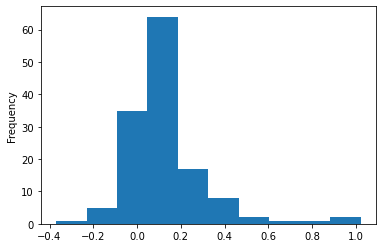

In [20]:
df_pred.loc[df_pred.index=='01-01-2019', 'factor_cng'].plot(kind='hist')

### Functions

In [21]:
def split_dataset(df, label=None):
    X = df
    
    if label:
        X = df.drop(label, axis=1)
        y = df[label]
        
        return X, y

    return X

In [22]:
def scaling(df, train_df=df, mode='train'):
    df.fillna(0, inplace=True)
    
    scaler = StandardScaler()
    
    if mode=='train':
        df_scaled = scaler.fit_transform(df)
        
    else:
        scaler.fit_transform(train_df)
        df_scaled = scaler.transform(df)
        
    return df_scaled

In [23]:
#split in train, cv and test set
train_df = df_pred.loc[(df_pred.index>='2011-01-01') & (df_pred.index<'2017-01-01'), :]
val_df = df_pred.loc[(df_pred.index=='2017-01-01') | (df_pred.index=='2018-01-01'), :]
test_df = df_pred.loc[df_pred.index=='2019-01-01', :]

In [24]:
joblib.dump(train_df, './dataframes/train_df_cng_2020.csv')
joblib.dump(val_df, './dataframes/val_df_cng_2020.csv')
joblib.dump(test_df, './dataframes/test_df_cng_2020.csv')

['./dataframes/test_df_cng_2020.csv']

In [25]:
train_df = joblib.load('./dataframes/train_df_cng_2020.csv')
val_df  = joblib.load('./dataframes/val_df_cng_2020.csv')
test_df = joblib.load('./dataframes/test_df_cng_2020.csv')

In [26]:
#split datasets in features and target
X_train, y_train = split_dataset(train_df, label='factor_cng')
X_cv, y_cv = split_dataset(val_df, label='factor_cng')
X_test, y_test = split_dataset(test_df, label='factor_cng')

In [27]:
#scale dataframes
scaled_X_train = pd.DataFrame(scaling(X_train, 'train'), columns=X_train.columns)
scaled_X_cv = pd.DataFrame(scaling(X_cv, X_train, 'cv'), columns=X_cv.columns)
scaled_X_test = pd.DataFrame(scaling(X_test, X_train, 'test'), columns=X_test.columns)

### XGBOOST

In [28]:
def modelfit(alg, dtrain, ttrain, dcv, tcv, dtest, ttest, predictors, useTrainCV=True, n_splits=5, early_stopping_rounds=50, plot_graph=True):  
    
    if useTrainCV:
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=ttrain.values)
        cvresult = xgb.cv(xgb_param,
                          xgtrain,
                          num_boost_round=alg.get_params()['n_estimators'],
                          #nfold=n_splits,
                          folds=tscv,
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval=5
                         )
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], ttrain)
        
    #Predict training set
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    #Predict cv set
    dcv_predictions = alg.predict(dcv[predictors])
    
    #Predict test set
    dtest_predictions = alg.predict(dtest[predictors])
        
    #Print model report:
    print("\nModel Report")
    print('-'*12)
    print('Mean Absolute Error on train set: {}'.format(str(mean_absolute_error(ttrain.values, dtrain_predictions))))
    print('Mean Absolute Error on cv set: {}'.format(str(mean_absolute_error(tcv.values, dcv_predictions))))
    print('Mean Absolute Error on test set: {}'.format(str(mean_absolute_error(ttest.values, dtest_predictions))))
    print('\n')

    if plot_graph:
        fig, ax = plt.subplots(1, 1, figsize=(15, 30))
        _ = xgb.plot_importance(alg, ax=ax, height=1.5)

#### Step 1 - Fix learning rate and number of estimators for tuning tree-based parameters

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

- max_depth = 5 : This should be between 3-10. 
- min_child_weight = 1
- gamma = 0 : A smaller value like 0.1-0.2 could also be chosen for starting. This will be tuned later.
- subsample, colsample_bytree = 0.8 : Typical values range between 0.5-0.9.
- scale_pos_weight = 1

All the above are just initial estimates and will be tuned later. We take the default learning rate of 0.1 here and check the optimum number of trees using the cv function of xgboost.

[0]	train-rmse:3.48403+6.13224	test-rmse:7.38818+13.90778
[5]	train-rmse:2.62778+4.71916	test-rmse:7.52142+13.83719
[10]	train-rmse:2.13419+3.90937	test-rmse:7.77652+13.74194
[15]	train-rmse:1.61541+2.97991	test-rmse:7.85420+13.71525
[20]	train-rmse:1.33569+2.48679	test-rmse:8.05094+13.65415
[25]	train-rmse:1.03102+1.91942	test-rmse:7.95915+13.67991
[30]	train-rmse:0.80399+1.49359	test-rmse:8.03165+13.65718
[35]	train-rmse:0.70220+1.30784	test-rmse:8.00420+13.66400
[40]	train-rmse:0.56804+1.05437	test-rmse:7.97149+13.67370
[45]	train-rmse:0.48999+0.90993	test-rmse:8.04423+13.65289
[50]	train-rmse:0.42028+0.77940	test-rmse:8.07432+13.64490

Model Report
------------
Mean Absolute Error on train set: 0.9073920980995053
Mean Absolute Error on cv set: 0.9634086747094808
Mean Absolute Error on test set: 0.6193698948703847




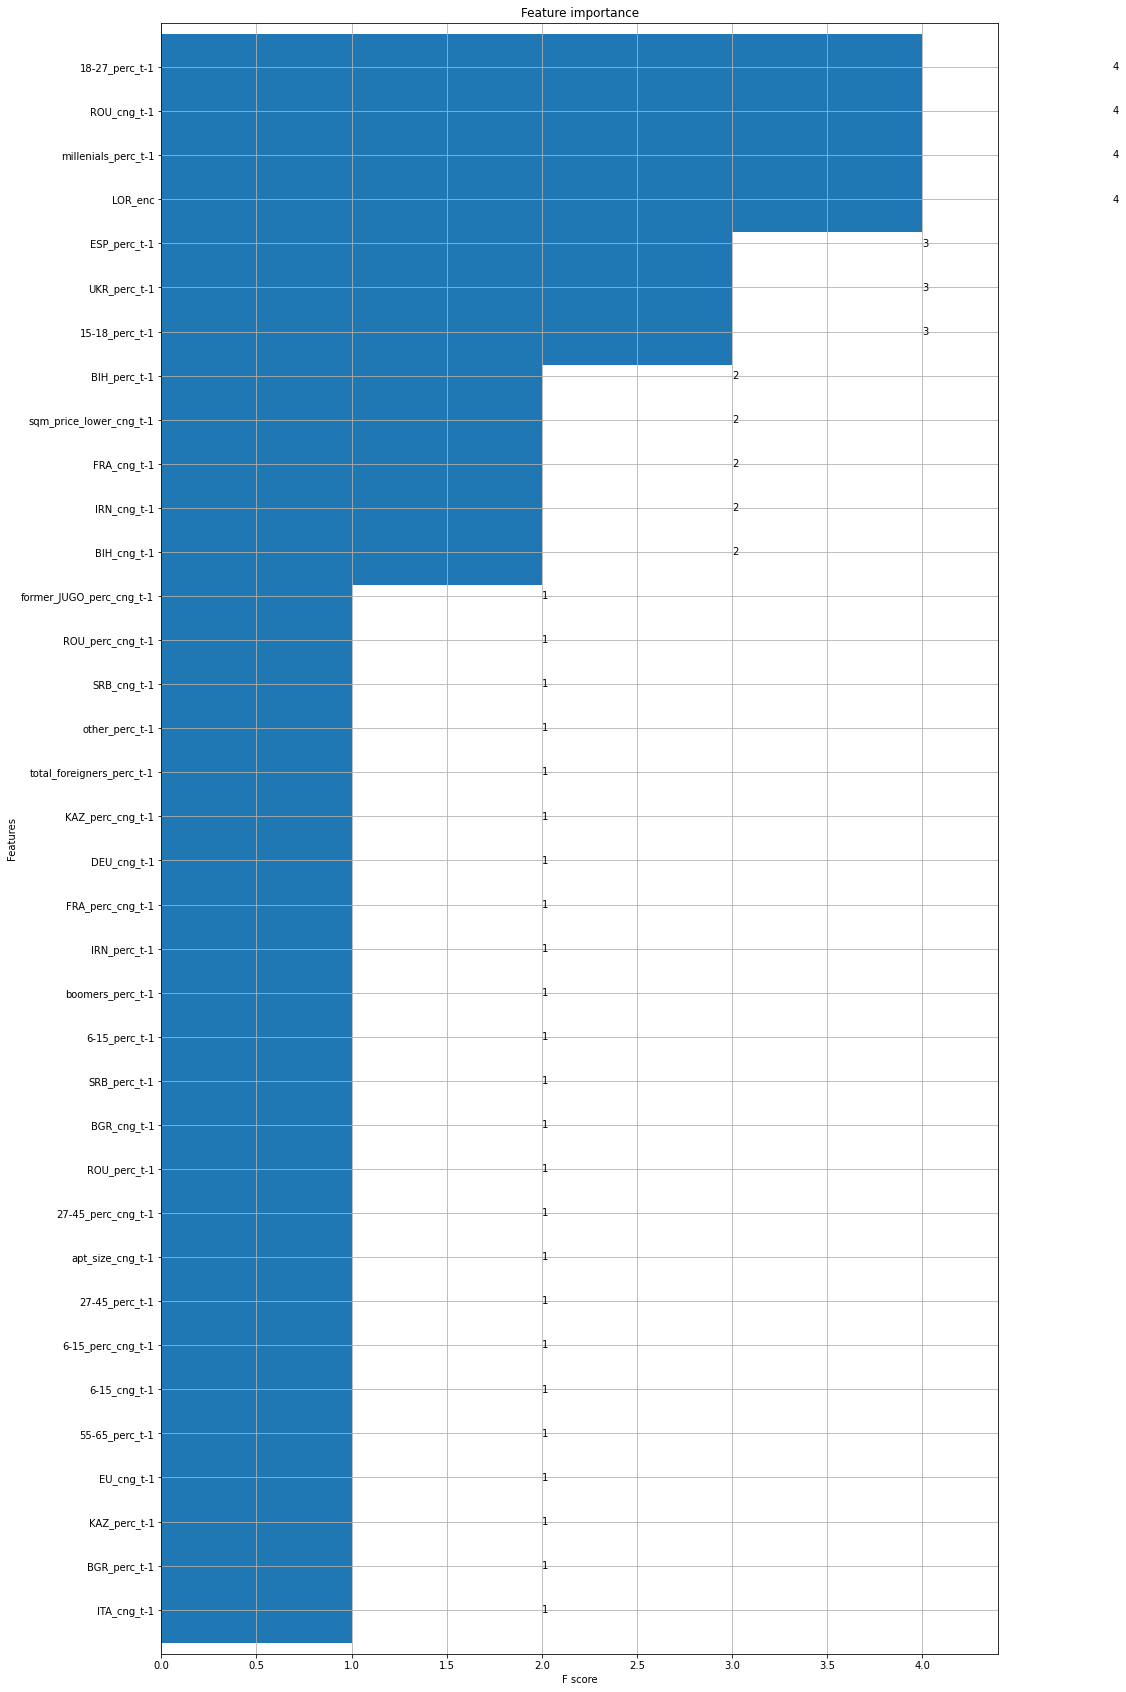

In [29]:
#Choose all predictors except ID_cols

predictors = [x for x in scaled_X_train.columns]

xgb_1 = xgb.XGBRegressor(
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=5,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective='reg:squarederror',
     nthread=4,
     scale_pos_weight=1,
     seed=42)

modelfit(xgb_1, scaled_X_train, y_train, scaled_X_cv, y_cv, scaled_X_test, y_test, predictors)

The best optimal estimators are between 80 and 85 (verbose_eval steps of 5) for 0.1 learning rate. We therefore pick n_estimators of 80.

#### Step 2: Tune max_depth and min_child_weight

We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

In [30]:
tscv = TimeSeriesSplit(n_splits=3)

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(2,8,2)
}

gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1,
                                                     n_estimators=100,
                                                     max_depth=5,
                                                     min_child_weight=1,
                                                     gamma=0,
                                                     subsample=0.8,
                                                     colsample_bytree=0.8,
                                                     objective='reg:squarederror',
                                                     nthread=4,
                                                     scale_pos_weight=1,
                                                     seed=42), 
                        param_grid = param_test1,
                        n_jobs=4,
                        cv=tscv)

gsearch1.fit(scaled_X_train[predictors], y_train)
gsearch1.cv_results_['params'], gsearch1.best_params_, gsearch1.best_score_

([{'max_depth': 3, 'min_child_weight': 2},
  {'max_depth': 3, 'min_child_weight': 4},
  {'max_depth': 3, 'min_child_weight': 6},
  {'max_depth': 5, 'min_child_weight': 2},
  {'max_depth': 5, 'min_child_weight': 4},
  {'max_depth': 5, 'min_child_weight': 6},
  {'max_depth': 7, 'min_child_weight': 2},
  {'max_depth': 7, 'min_child_weight': 4},
  {'max_depth': 7, 'min_child_weight': 6},
  {'max_depth': 9, 'min_child_weight': 2},
  {'max_depth': 9, 'min_child_weight': 4},
  {'max_depth': 9, 'min_child_weight': 6}],
 {'max_depth': 5, 'min_child_weight': 2},
 -0.06807809894619136)

We ran 12 combinations with wider intervals between values. The ideal values are 9 for max_depth and 2 for min_child_weight. Let's go one step deeper and look for optimum values. We’ll search for values 1 above and below the optimum values because we took an interval of two.

In [31]:
param_test2 = {
 'max_depth': [4, 5, 6],
 'min_child_weight': [1, 2, 3]
}

gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1,
                                                     n_estimators=135,
                                                     max_depth=5,
                                                     min_child_weight=2,
                                                     gamma=0,
                                                     subsample=0.8,
                                                     colsample_bytree=0.8,
                                                     objective='reg:squarederror',
                                                     nthread=4,
                                                     scale_pos_weight=1,
                                                     seed=42), 
                        param_grid = param_test2,
                        n_jobs=4,
                        cv=tscv)

gsearch2.fit(scaled_X_train[predictors], y_train)
gsearch2.cv_results_['params'], gsearch2.best_params_, gsearch2.best_score_

([{'max_depth': 4, 'min_child_weight': 1},
  {'max_depth': 4, 'min_child_weight': 2},
  {'max_depth': 4, 'min_child_weight': 3},
  {'max_depth': 5, 'min_child_weight': 1},
  {'max_depth': 5, 'min_child_weight': 2},
  {'max_depth': 5, 'min_child_weight': 3},
  {'max_depth': 6, 'min_child_weight': 1},
  {'max_depth': 6, 'min_child_weight': 2},
  {'max_depth': 6, 'min_child_weight': 3}],
 {'max_depth': 4, 'min_child_weight': 2},
 -0.03713436451873683)

Now we get the optimum values as 10 for max_depth and 3 for min_child_weight. Also, we can see the CV score increased.

#### Step 3: Tune gamma

Now lets tune gamma value using the parameters already tuned above.

In [32]:
param_test3 = {
 'gamma':[i/20.0 for i in range(0, 10)]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1,
                                                     n_estimators=100,
                                                     max_depth=4,
                                                     min_child_weight=2,
                                                     gamma=0,
                                                     subsample=0.8,
                                                     colsample_bytree=0.8,
                                                     objective='reg:squarederror',
                                                     nthread=4,
                                                     scale_pos_weight=1,
                                                     seed=42), 
                        param_grid = param_test3,
                        n_jobs=4,
                        cv=tscv)

gsearch3.fit(scaled_X_train[predictors], y_train)
gsearch3.cv_results_['params'], gsearch3.best_params_, gsearch3.best_score_

([{'gamma': 0.0},
  {'gamma': 0.05},
  {'gamma': 0.1},
  {'gamma': 0.15},
  {'gamma': 0.2},
  {'gamma': 0.25},
  {'gamma': 0.3},
  {'gamma': 0.35},
  {'gamma': 0.4},
  {'gamma': 0.45}],
 {'gamma': 0.2},
 0.010536770131412151)

We select a gamma of 0.1. Before proceeding, we are going to re-calibrate the number of boosting rounds for the updated parameters.

[0]	train-rmse:3.48486+6.13204	test-rmse:7.38480+13.91084
[5]	train-rmse:2.63273+4.71658	test-rmse:7.51702+13.84606
[10]	train-rmse:2.15813+3.93077	test-rmse:7.74513+13.75821
[15]	train-rmse:1.63906+2.98274	test-rmse:7.82154+13.73026
[20]	train-rmse:1.38270+2.51477	test-rmse:8.17770+13.62627
[25]	train-rmse:1.14239+2.05436	test-rmse:8.03909+13.66119
[30]	train-rmse:0.92949+1.63993	test-rmse:8.10004+13.64299
[35]	train-rmse:0.84734+1.48307	test-rmse:8.09469+13.64302
[40]	train-rmse:0.73652+1.26718	test-rmse:8.06097+13.65053
[45]	train-rmse:0.68292+1.16442	test-rmse:8.04852+13.65273
[50]	train-rmse:0.63583+1.07203	test-rmse:8.09615+13.64010

Model Report
------------
Mean Absolute Error on train set: 0.9017044428853676
Mean Absolute Error on cv set: 0.695012408947092
Mean Absolute Error on test set: 0.5324190404439987




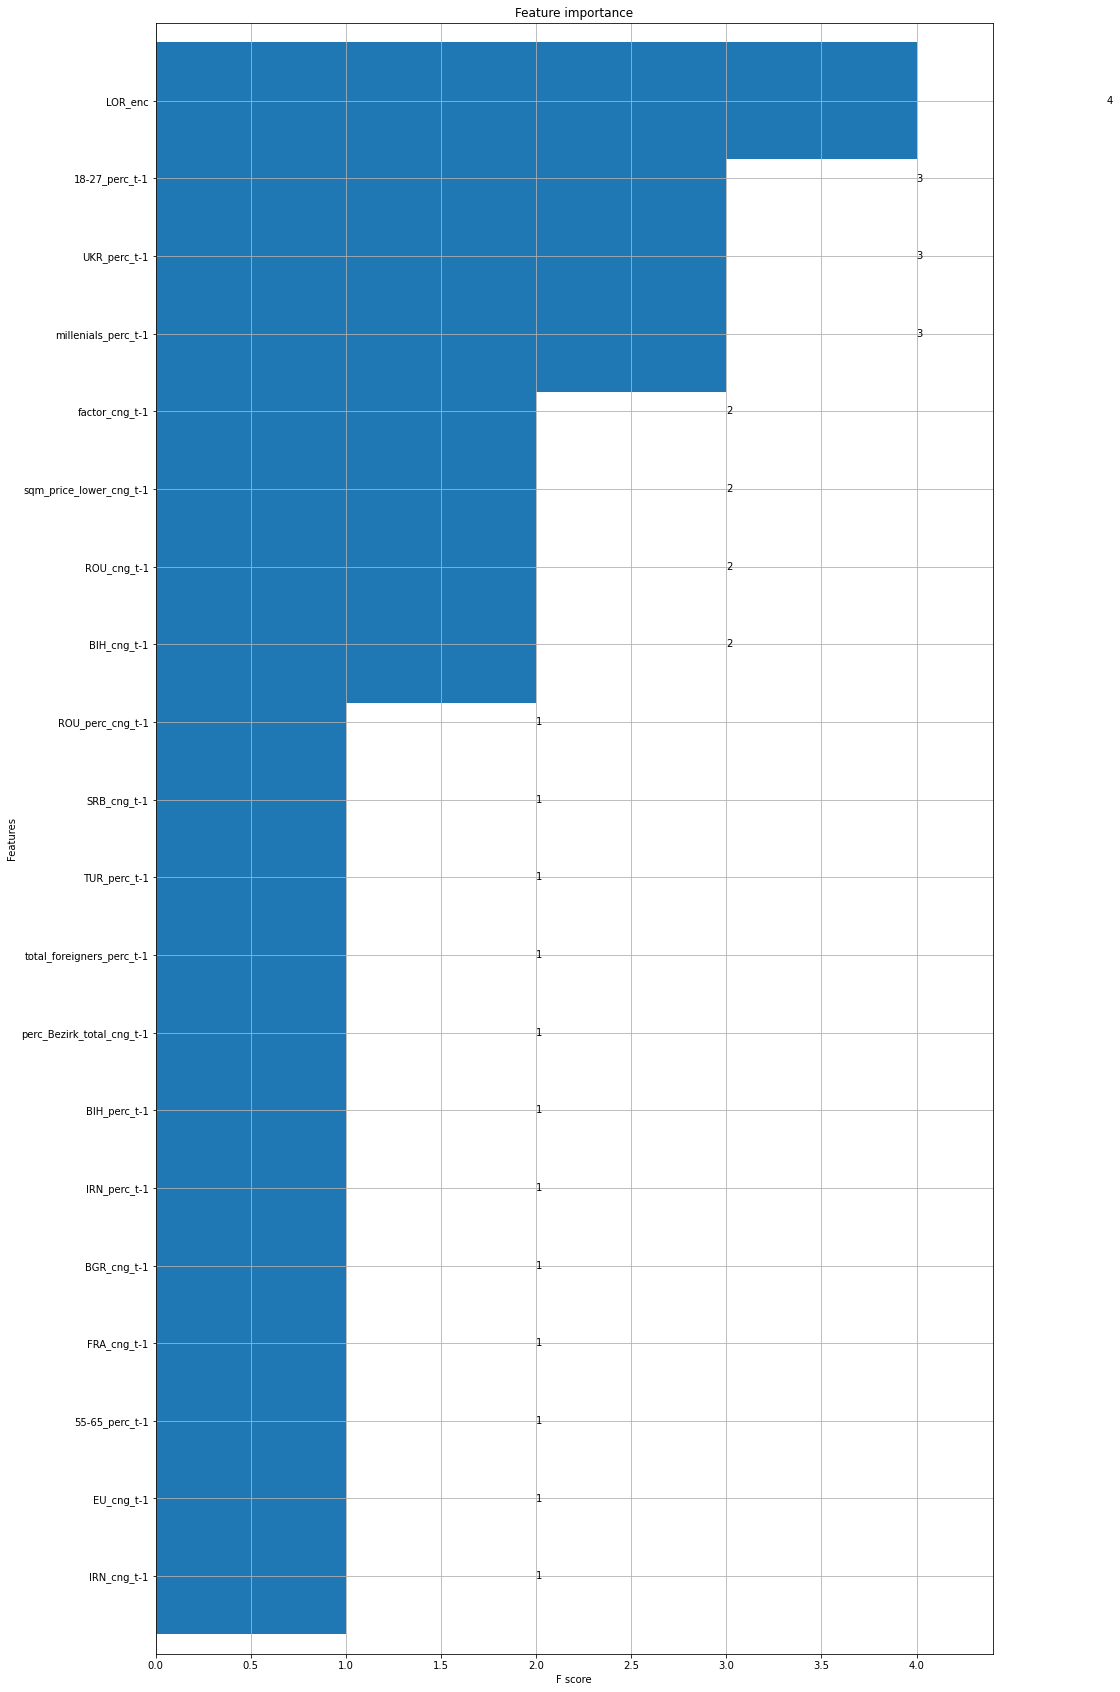

In [33]:
xgb_2 = xgb.XGBRegressor(
     learning_rate=0.1,
     n_estimators=1000,
     max_depth=4,
     min_child_weight=2,
     gamma=0.2,
     subsample=0.8,
     colsample_bytree=0.8,
     objective='reg:squarederror',
     nthread=4,
     scale_pos_weight=1,
     seed=42)

modelfit(xgb_2, scaled_X_train, y_train, scaled_X_cv, y_cv, scaled_X_test, y_test, predictors)

Optimal n_estimatot changes to 125.

#### Step 4: Tune subsample and colsample_bytree

In [34]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1,
                                                     n_estimators=100,
                                                     max_depth=4,
                                                     min_child_weight=2,
                                                     gamma=0.2,
                                                     subsample=0.8,
                                                     colsample_bytree=0.8,
                                                     objective='reg:squarederror',
                                                     nthread=4,
                                                     scale_pos_weight=1,
                                                     seed=42), 
                        param_grid = param_test4,
                        n_jobs=4,
                        cv=tscv)

gsearch4.fit(scaled_X_train[predictors], y_train)
gsearch4.cv_results_['params'], gsearch4.best_params_, gsearch4.best_score_

([{'colsample_bytree': 0.6, 'subsample': 0.6},
  {'colsample_bytree': 0.6, 'subsample': 0.7},
  {'colsample_bytree': 0.6, 'subsample': 0.8},
  {'colsample_bytree': 0.6, 'subsample': 0.9},
  {'colsample_bytree': 0.7, 'subsample': 0.6},
  {'colsample_bytree': 0.7, 'subsample': 0.7},
  {'colsample_bytree': 0.7, 'subsample': 0.8},
  {'colsample_bytree': 0.7, 'subsample': 0.9},
  {'colsample_bytree': 0.8, 'subsample': 0.6},
  {'colsample_bytree': 0.8, 'subsample': 0.7},
  {'colsample_bytree': 0.8, 'subsample': 0.8},
  {'colsample_bytree': 0.8, 'subsample': 0.9},
  {'colsample_bytree': 0.9, 'subsample': 0.6},
  {'colsample_bytree': 0.9, 'subsample': 0.7},
  {'colsample_bytree': 0.9, 'subsample': 0.8},
  {'colsample_bytree': 0.9, 'subsample': 0.9}],
 {'colsample_bytree': 0.6, 'subsample': 0.8},
 0.03096129777037837)

Here, we found 0.9 as the optimum value for subsample and colsample_bytree. Now we try values in 0.05 interval around these.

In [35]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75, 90, 5)],
 'colsample_bytree':[i/100.0 for i in range(55, 70, 5)]
}

gsearch5 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1,
                                                     n_estimators=100,
                                                     max_depth=4,
                                                     min_child_weight=2,
                                                     gamma=0.2,
                                                     subsample=0.8,
                                                     colsample_bytree=0.6,
                                                     objective='reg:squarederror',
                                                     nthread=4,
                                                     scale_pos_weight=1,
                                                     seed=42), 
                        param_grid = param_test5,
                        n_jobs=4,
                        cv=tscv)

gsearch5.fit(scaled_X_train[predictors], y_train)
gsearch5.cv_results_['params'], gsearch5.best_params_, gsearch5.best_score_

([{'colsample_bytree': 0.55, 'subsample': 0.75},
  {'colsample_bytree': 0.55, 'subsample': 0.8},
  {'colsample_bytree': 0.55, 'subsample': 0.85},
  {'colsample_bytree': 0.6, 'subsample': 0.75},
  {'colsample_bytree': 0.6, 'subsample': 0.8},
  {'colsample_bytree': 0.6, 'subsample': 0.85},
  {'colsample_bytree': 0.65, 'subsample': 0.75},
  {'colsample_bytree': 0.65, 'subsample': 0.8},
  {'colsample_bytree': 0.65, 'subsample': 0.85}],
 {'colsample_bytree': 0.6, 'subsample': 0.75},
 0.05921804460588317)

We got the same values as before. Thus the optimum values are:
- subsample: 0.9
- colsample_bytree: 0.9

#### Step 5: Tuning Regularization Parameters

In [36]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0,  0.1, 1, 100]
}

gsearch6 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1,
                                                     n_estimators=100,
                                                     max_depth=4,
                                                     min_child_weight=2,
                                                     gamma=0.2,
                                                     subsample=0.75,
                                                     colsample_bytree=0.6,
                                                     objective='reg:squarederror',
                                                     nthread=4,
                                                     scale_pos_weight=1,
                                                     seed=42), 
                        param_grid = param_test6,
                        n_jobs=4,
                        cv=tscv)

gsearch6.fit(scaled_X_train[predictors], y_train)
gsearch6.cv_results_['params'], gsearch6.best_params_, gsearch6.best_score_

([{'reg_alpha': 1e-05},
  {'reg_alpha': 0.01},
  {'reg_alpha': 0},
  {'reg_alpha': 0.1},
  {'reg_alpha': 1},
  {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.05921812351964547)

We are going to apply a regulatization of 100.

Now we can apply let's check the model and look at the impact of the hyperparameters tuned so far:

[0]	train-rmse:3.48511+6.13127	test-rmse:7.38359+13.91126
[5]	train-rmse:2.63374+4.71573	test-rmse:7.51454+13.84988
[10]	train-rmse:2.16017+3.93195	test-rmse:7.66323+13.78783
[15]	train-rmse:1.64678+2.99311	test-rmse:7.76872+13.75077
[20]	train-rmse:1.39957+2.54721	test-rmse:7.79715+13.74386
[25]	train-rmse:1.14636+2.06286	test-rmse:7.77204+13.75048
[30]	train-rmse:0.96029+1.70175	test-rmse:7.85875+13.71889
[35]	train-rmse:0.88045+1.54838	test-rmse:7.93690+13.69308
[40]	train-rmse:0.75272+1.29690	test-rmse:7.94070+13.69138
[45]	train-rmse:0.70892+1.21132	test-rmse:7.97606+13.68041
[50]	train-rmse:0.66108+1.11809	test-rmse:8.03356+13.66280

Model Report
------------
Mean Absolute Error on train set: 0.9060053785827213
Mean Absolute Error on cv set: 0.5240375341842928
Mean Absolute Error on test set: 0.4640301518691489




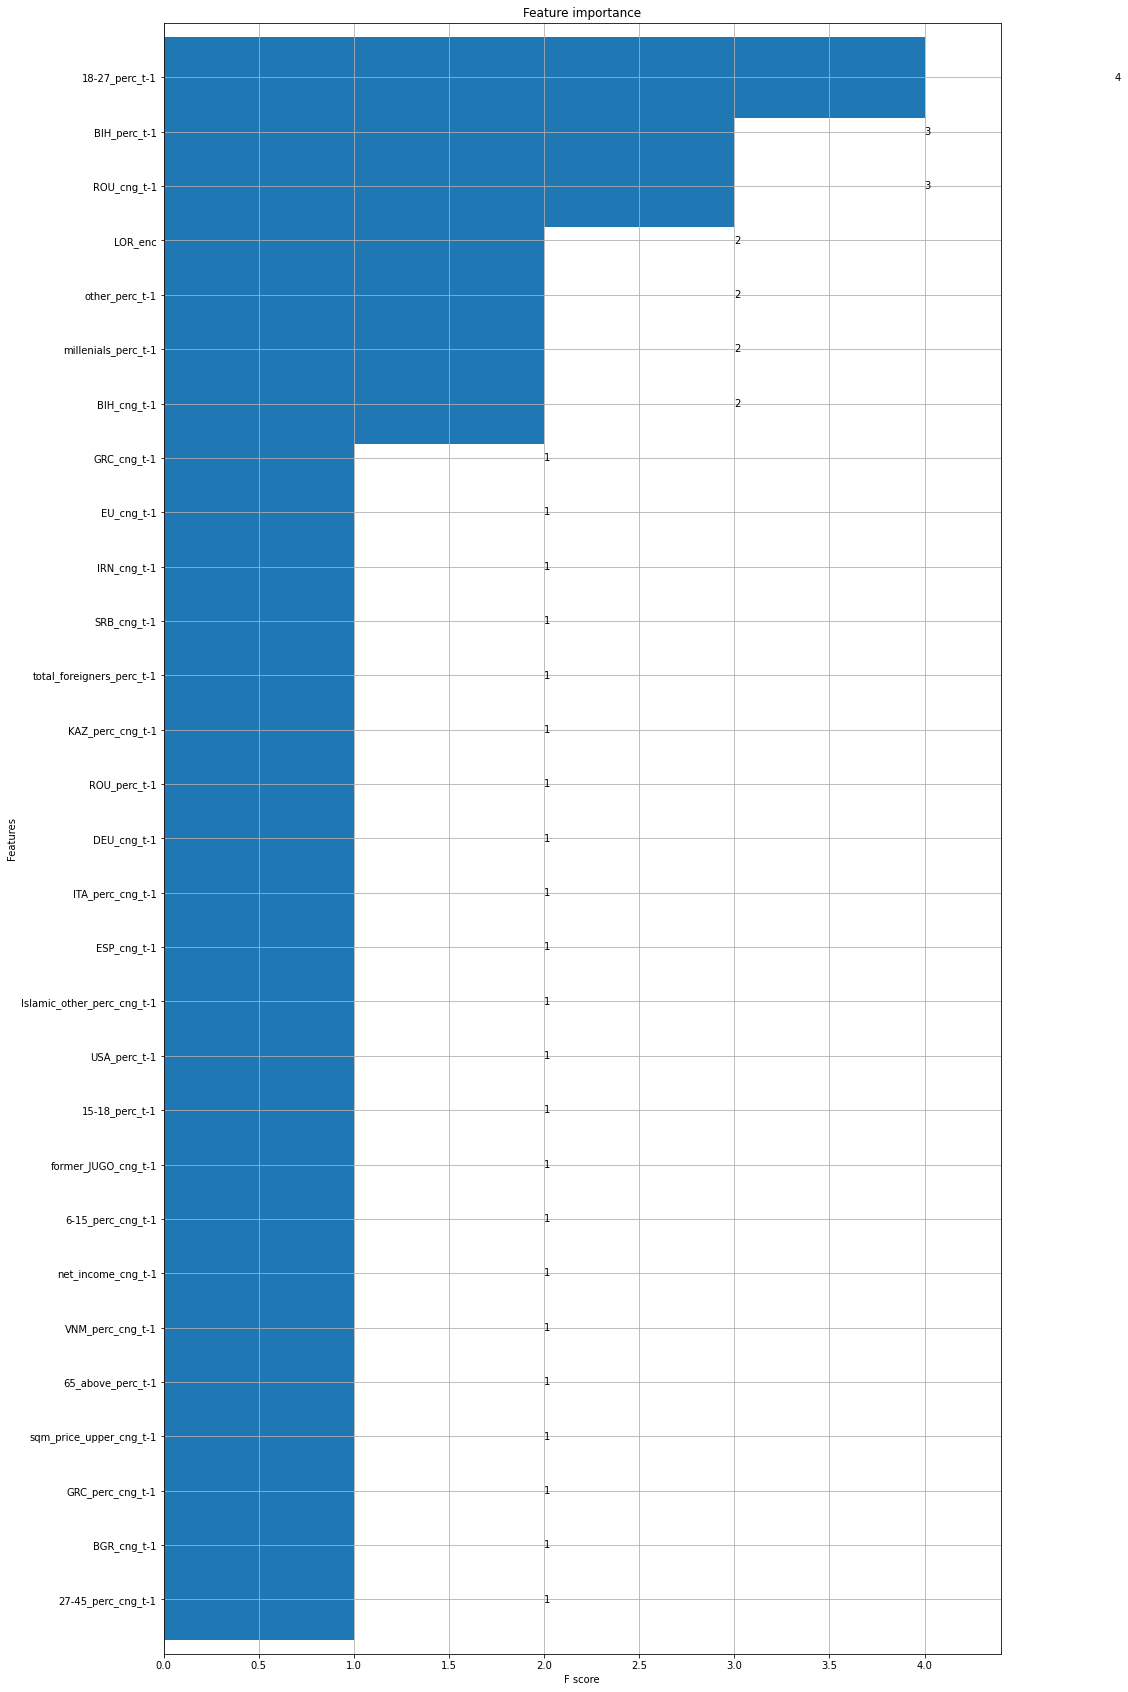

In [37]:
xgb_3 = xgb.XGBRegressor(
     learning_rate=0.1,
     n_estimators=1000,
     max_depth=4,
     min_child_weight=2,
     gamma=0.2,
     subsample=0.75,
     colsample_bytree=0.6,
     #reg_alpha=0.01,
     objective='reg:squarederror',
     nthread=4,
     scale_pos_weight=1,
     seed=42)

modelfit(xgb_3, scaled_X_train, y_train, scaled_X_cv, y_cv, scaled_X_test, y_test, predictors)

#### Step 6: Reducing Learning Rate

Lastly, we are going to lower the learning rate and add more trees.

In [38]:
for lr in [0.01, 0.03, 0.1, 0.3, 1]:
    print(lr, '\n-------')
    xgb_4 = xgb.XGBRegressor(
         learning_rate=lr,
         n_estimators=1000,
         max_depth=4,
         min_child_weight=2,
         gamma=0.2,
         subsample=0.75,
         colsample_bytree=0.6,
         #reg_alpha=0.01,
         objective='reg:squarederror',
         nthread=4,
         scale_pos_weight=1,
         seed=42)

    modelfit(xgb_4, scaled_X_train, y_train, scaled_X_cv, y_cv, scaled_X_test, y_test, predictors, plot_graph=False)

0.01 
-------
[0]	train-rmse:3.51386+6.11793	test-rmse:7.40680+13.89940
[5]	train-rmse:3.41675+5.96197	test-rmse:7.40232+13.90106
[10]	train-rmse:3.34249+5.85015	test-rmse:7.41078+13.89693
[15]	train-rmse:3.24027+5.68049	test-rmse:7.42226+13.89132
[20]	train-rmse:3.17520+5.58325	test-rmse:7.43767+13.88356
[25]	train-rmse:3.09339+5.45101	test-rmse:7.44153+13.88254
[30]	train-rmse:3.00215+5.29858	test-rmse:7.48387+13.86311
[35]	train-rmse:2.93962+5.20157	test-rmse:7.52787+13.84320
[40]	train-rmse:2.84390+5.03700	test-rmse:7.54502+13.83573
[45]	train-rmse:2.80496+4.98446	test-rmse:7.57853+13.82153
[50]	train-rmse:2.74329+4.88519	test-rmse:7.59461+13.81513

Model Report
------------
Mean Absolute Error on train set: 1.091257767063011
Mean Absolute Error on cv set: 0.3372188851098935
Mean Absolute Error on test set: 0.39849991933469964


0.03 
-------
[0]	train-rmse:3.50744+6.12091	test-rmse:7.40157+13.90207
[5]	train-rmse:3.22447+5.66282	test-rmse:7.41476+13.89409
[10]	train-rmse:3.02273+5

### Final Model t-1

[0]	train-rmse:3.42287+6.16026	test-rmse:7.33563+13.93586
[5]	train-rmse:1.50542+2.73630	test-rmse:7.69025+13.76755
[10]	train-rmse:0.99023+1.75903	test-rmse:7.68792+13.76201
[15]	train-rmse:0.61360+1.02162	test-rmse:7.87442+13.69634
[20]	train-rmse:0.48558+0.77302	test-rmse:7.86571+13.69905
[25]	train-rmse:0.37647+0.55615	test-rmse:7.91801+13.68304
[30]	train-rmse:0.30109+0.40657	test-rmse:7.91810+13.68247
[35]	train-rmse:0.26941+0.34456	test-rmse:7.93897+13.67603
[40]	train-rmse:0.21294+0.23280	test-rmse:7.97583+13.66414
[45]	train-rmse:0.18806+0.18533	test-rmse:7.97083+13.66377
[50]	train-rmse:0.15914+0.13020	test-rmse:7.98987+13.65774

Model Report
------------
Mean Absolute Error on train set: 0.6314978419649077
Mean Absolute Error on cv set: 0.7388912737670642
Mean Absolute Error on test set: 0.5250726014671446




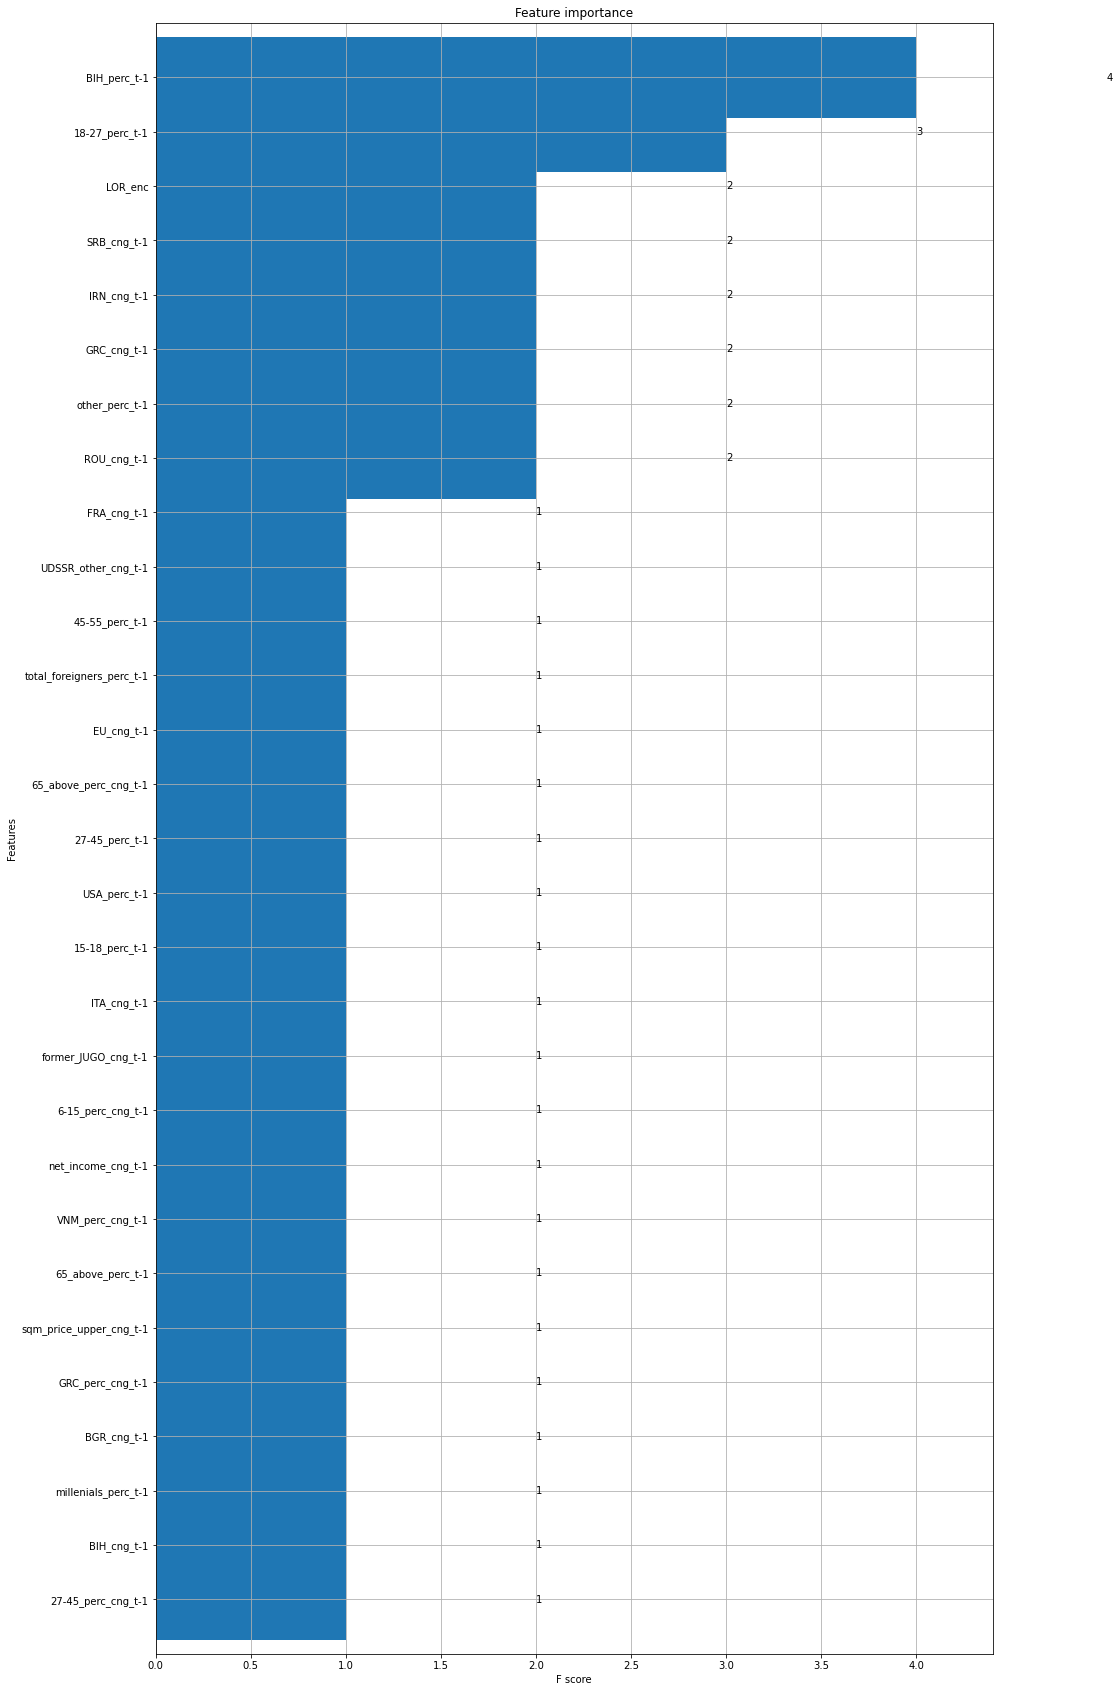

In [39]:
xgb_6 = xgb.XGBRegressor(
        learning_rate=0.3,
        n_estimators=5000,
        max_depth=4,
        min_child_weight=2,
        gamma=0.2,
        subsample=0.75,
        colsample_bytree=0.6,
        #reg_alpha=0.01,
        objective='reg:squarederror',
        nthread=4,
        scale_pos_weight=1,
        seed=42)

modelfit(xgb_6, scaled_X_train, y_train, scaled_X_cv, y_cv, scaled_X_test, y_test, predictors, predictors)

### Predicting on 2020

In [40]:
add_cols = ['PLZ_t-1', 'area_t-1', 'area_sqkm_t-1', 'living_area_t-1', 'leisure_area_t-1', 'leisure_part_t-1',
            'lower_quality_t-1', 'average_quality_t-1', 'upper_quality_t-1', 'LOR_enc', 'factor_cng']

In [41]:
features_shift = [c for c in df_pred.columns if 'cng_t-1' in c or 'perc_t-1' in c or c in add_cols]
features = [c[:-4] for c in features_shift if c not in ['LOR_enc', 'factor_cng']]
features.append('LOR_enc')
features.append('factor')

In [42]:
#X_train_2020 = pd.concat([scaled_X_train[boost_features_shift], scaled_X_cv[boost_features_shift], scaled_X_test[boost_features_shift]], axis=0)
#y_train_2020 = pd.concat([y_train, y_cv,  y_test], axis=0)

df_2020 = df[features_shift]
X_train_2020, y_train_2020 = split_dataset(df_2020, 'factor_cng')

X_pred_2020 = df.loc[df['year']==2019, features]
X_pred_2020.drop('factor_cng', axis=1, inplace=True)
X_pred_2020.columns = X_train_2020.columns

In [43]:
X_train_2020_scaled = scaling(X_train_2020, train_df=X_train_2020, mode='train')
X_pred_2020_scaled = scaling(X_pred_2020, train_df=X_train_2020, mode='test')

In [44]:
y_train_2020 = y_train_2020.fillna(0)

In [45]:
xgb_final = xgb.XGBRegressor(
        learning_rate=0.3,
        n_estimators=100,
        max_depth=4,
        min_child_weight=2,
        gamma=0.2,
        subsample=0.75,
        colsample_bytree=0.6,
        #reg_alpha=0.01,
        objective='reg:squarederror',
        nthread=4,
        scale_pos_weight=1,
        seed=42)

In [46]:
#Fit the algorithm on the data
xgb_final.fit(X_train_2020, y_train_2020)
predictions_all = xgb_final.predict(X_train_2020)
print('Mean Absolute Error on train set: {}'.format(str(mean_absolute_error(y_train_2020.values, predictions_all))))

predictions_2020 = xgb_final.predict(X_pred_2020)

Mean Absolute Error on train set: 0.07377372114306575


In [47]:
preds_2020 = pd.concat([df.loc[df['year']==2019, 'Bezirksname'].reset_index(drop=True), pd.Series(predictions_2020)], axis=1)
preds_2020.columns = ['Bezirksname', 'factor_cng']

In [48]:
joblib.dump(preds_2020, './dataframes/predictions_2020_cng.csv')

['./dataframes/predictions_2020_cng.csv']